In [1]:
import torch, os
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


## 建立資料集: 
### 最後圖片大小為 [1,128,128]

In [2]:
class HandDataset(Dataset):
    def __init__(self, annotation_dir, root_dir, transform=None, target_transform=None ):
        self.img_labels = pd.read_csv(annotation_dir) # csv 檔案路徑
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)


    def __getitem__(self, index):
        img_path = self.root_dir + self.img_labels.iloc[index,1]        # 獲得圖片位置
        image = Image.open(img_path)                                    # 得到圖片檔案

        #　圖片前處理
        img_transforms = transforms.Compose([
            transforms.Resize([130,130]),
            # transforms.Grayscale(),                 # 灰階圖片
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) ])
        image = img_transforms(image)

        label = self.img_labels.iloc[index,2]                           # 讀取圖片 label
        if self.transform:                                              # 其實已經有用 tv.io.read_image 把圖片轉 Tensor 通常不會用到此
            image = self.transform(image)                               # 沒用 read_image 通常這邊會使用 toTensor()

        return image, label

In [3]:
# label 檔位置
train_label_dir = './train.csv'
test_label_dir = './test.csv'
# 圖片檔位置
train_dir = './Hand_data/train_data'
test_dir = './Hand_data/test_data'

train_data = HandDataset(train_label_dir, train_dir)
test_data = HandDataset(test_label_dir, test_dir )

##
## 分成 batch

In [4]:
batch_size = 10
epochs = 120
lr = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

Using device cuda


In [5]:
train_dataloader = DataLoader(train_data, batch_size, shuffle=True )
test_dataloader = DataLoader(test_data, batch_size, shuffle=True )

In [6]:
"""for batch ,(X,y) in enumerate(train_dataloader):           # 讀入 batch 的 X,y 和目前的跑過的 batch 編號
    # print(X)
    print(y)
# list(enumerate(train_dataloader))"""

'for batch ,(X,y) in enumerate(train_dataloader):           # 讀入 batch 的 X,y 和目前的跑過的 batch 編號\n    # print(X)\n    print(y)\n# list(enumerate(train_dataloader))'

##
## 建構神經網路

In [7]:
class NeuronNetwork(nn.Module):
    def __init__(self):
        super().__init__()                      # 父類別初始函數
        self.flatten = nn.Flatten()             

        self.layer1 = nn.Sequential(            # input (,3,130,130)
            nn.Conv2d( in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0 ),  # out (64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # out (,64, 64, 64)
        )

        self.layer2 = nn.Sequential(            
            nn.Conv2d( in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0 ), # out (,32, 62, 62)  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # out (,32, 31, 31)
        )


        self.fc1 = nn.Linear( in_features=32*31*31, out_features=128 )
        self.fc2 = nn.Linear(128, 4)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = nn.Dropout(0.5)(out)
        out = self.fc2(out)
        out = nn.Softmax(dim=1)(out)
        return out


In [8]:
# 建立模型
model = NeuronNetwork().to(device)
print(model)

NeuronNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=30752, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


##
## 訓練網路

In [9]:
acc_list = []
loss_list = []

In [10]:
# 定義訓練函數 ( 訓練的資料, 網路模型, 使用的loss funciton, 使用的優化器 )
def train_loop( dataloader, model, loss_func, optimizer ):
    size = len(dataloader.dataset)                       # 總 data 大小(印出用)
    for batch ,(X,y) in enumerate(dataloader):           # 讀入 batch 的 X,y 和目前的跑過的 batch 編號

        # 計算 X預測值和loss
        X = X.to(device)                                 # 將 X 放到 GPU 做計算 
        y = y.to(device)                                 # 將 y 放到 GPU 做計算
        #print("X,y is ok")
        pred = model(X)
        #print("pred is ok")
        loss = loss_func( pred, y )
        #print("loss is ok")

        # BackPropagation (反向傳播)
        optimizer.zero_grad()                           # 每次訓練前會將[梯度]重設為0
        loss.backward()                                 # 進行反向傳播
        optimizer.step()                                # 參數(w,bias)更新

        # 每跑過 100 個 batch，印出訓練資訊
        if batch % 10 == 0:                            
            loss = loss.item()                          # 提取 loss 值
            loss_list.append(loss)
            current = batch * len(X)                    # 現在跑過的資料數( len(X)為每 batch 資料數 )
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")   # [:>] 代表印出格式



# 定義測試函數 (測試的資料, 網路模型, loss function )
def test_loop( dataloader, model, loss_func ):
    size = len(dataloader.dataset) 
    num_batchs = len(dataloader)                        # batch 的數量(測試集)
    test_loss, correct = 0, 0
    for X,y in dataloader:                              # 讀入測試集的 X,y
        X = X.to(device)                                 # 將 X 放到 GPU 做計算 
        y = y.to(device)                                 # 將 y 放到 GPU 做計算
        pred = model(X)
        test_loss += loss_func(pred,y).item()           # 得到所有的loss的加總
        correct += ( pred.argmax(1) == y ).type(torch.float).sum().item()   # 得到分類預測正確的數量


    test_loss = test_loss / num_batchs                  # 計算平均 loss
    accuracy = correct / size                           # 計算準確度 ( 預測對的資料 / 全部資料 )
    acc_list.append(accuracy)
    print(f"Test Error:\n Accuracy: {100* accuracy :>0.1f}%  Avg Loss:{test_loss :>8f}\n")

In [11]:
# 定義 loss function 和 優化器
loss_func = nn.CrossEntropyLoss()       # 使用交叉商當 loss function
optimizer = torch.optim.SGD( params = model.parameters(), lr=lr )       # (要更新的參數, learning rate)

# 開始訓練
for t in range(epochs):
    print(f"Epoch: {t+1}\n------------------") 
    train_loop( train_dataloader, model, loss_func, optimizer )
    test_loop( test_dataloader, model, loss_func )

print("done")

Epoch: 1
------------------
loss: 1.366585 [    0/  804]
loss: 1.397349 [  100/  804]
loss: 1.399464 [  200/  804]
loss: 1.378990 [  300/  804]
loss: 1.405775 [  400/  804]
loss: 1.375569 [  500/  804]
loss: 1.370478 [  600/  804]
loss: 1.379493 [  700/  804]
loss: 1.376379 [  320/  804]
Test Error:
 Accuracy: 31.2%  Avg Loss:1.376097

Epoch: 2
------------------
loss: 1.374403 [    0/  804]
loss: 1.351991 [  100/  804]
loss: 1.372206 [  200/  804]
loss: 1.356621 [  300/  804]
loss: 1.371902 [  400/  804]
loss: 1.358649 [  500/  804]
loss: 1.366751 [  600/  804]
loss: 1.363648 [  700/  804]
loss: 1.376725 [  320/  804]
Test Error:
 Accuracy: 44.8%  Avg Loss:1.369818

Epoch: 3
------------------
loss: 1.370960 [    0/  804]
loss: 1.359638 [  100/  804]
loss: 1.354026 [  200/  804]
loss: 1.352738 [  300/  804]
loss: 1.365056 [  400/  804]
loss: 1.355901 [  500/  804]
loss: 1.348908 [  600/  804]
loss: 1.356727 [  700/  804]
loss: 1.341818 [  320/  804]
Test Error:
 Accuracy: 47.9%  Avg L

In [12]:
print(len(loss_list))

1080


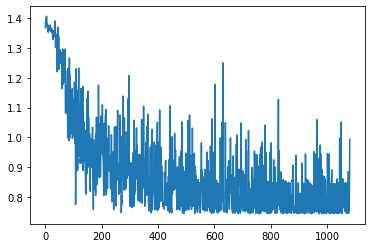

In [13]:
# loss 變動圖
loss_times_list = range(1,len(loss_list)+1)
plt.plot(loss_times_list, loss_list)
plt.show()


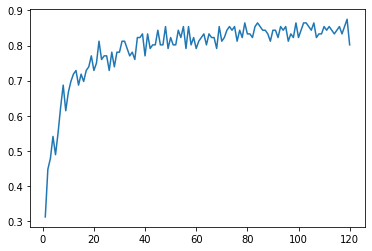

In [14]:
# Model Accuracy 變動圖
epochs_list = range(1,epochs+1)
plt.plot(epochs_list, acc_list)
plt.show()

In [15]:
torch.save( model, 'model_6.pth' )